In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
!pip install komm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for komm: filename=komm-0.7.1-py3-none-any.whl size=56606 sha256=94fb270e6159b63d662b7312453e1ac40bf1681df14a327e2b3fed079cc17df7
  Stored in directory: /root/.cache/pip/wheels/35/e1/84/a6103ea23ad8f09ac58da5e8dfffac14591b07b96b9fdddcc0
Successfully built komm


In [4]:
import datagen
import matplotlib.pyplot as plt



In [5]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/My Drive/model50K')

In [6]:
# Get probability of False Alarm 
noiseSamples = datagen.genNoiseFile(NumberOfRecordings= 50000)
# np.save("noInterference.npy", noiseSamples)


(50000, 500)


In [7]:
noiseSamples.shape

(50000, 500)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import datagen



def genDopplerShiftedSine(SNR, kHzShift):

    HzShift = (kHzShift) * 1000 
    sine = datagen.genSineWaveNoise(Ns= 600, SNR = SNR,fs = 2048000,fc = 500000 + HzShift)
    # plt.plot(sine)
    # plt.plot(datagen.genNoise(Ns=200))    
    # plt.show()
    downconverted = datagen.convertToIQ(sine, fs = 2048000, fReciever = 500000 )
    # print(downconverted.shape)
    downconvertedComplex = downconverted[0,:] + 1j * downconverted[1,:]

    downconvertedComplex /= np.max(np.abs(downconvertedComplex))
    # plt.plot(np.real(downconvertedComplex))
    # plt.plot(np.imag(downconvertedComplex))
    # plt.show()
    return downconvertedComplex






sample = genDopplerShiftedSine(-1000, 0)


In [ ]:

  
matchedFilters = np.zeros((100,500),dtype = complex)
for i in range(100):
  print("KHz Shift:", i)
  matchedFilters[i,:] = genDopplerShiftedSine(100, i)
  plt.plot(np.real(matchedFilters[i,:]))
  plt.plot(np.imag(matchedFilters[i,:]))
  plt.show()

NameError: ignored

In [ ]:
# noiseSamples = noiseSamples[:,:,0] + 1j * noiseSamples[:,:,1]

In [ ]:
plt.plot(noiseSamples[1,:])
plt.show()

In [ ]:
temp =  genDopplerShiftedSine(-20, 0)
noise = noiseSamples[2,:]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


temp =  genDopplerShiftedSine(-5, 0)
noise = datagen.convertToIQ(datagen.genNoise(Ns=500),fReciever=1024000,fs=2048000)
print(noise.shape)
noise = noise[0,:] + 1j * noise[1,:]

noise = noise / np.max(np.abs(noise))

plt.plot(np.real(temp))
plt.plot(np.imag(temp))
plt.plot(np.angle(temp))
plt.show()
plt.plot(np.real(noise))
plt.plot(np.imag(noise))
plt.plot(np.angle(noise))
plt.show()

In [ ]:
noiseSamples.shape

In [9]:
noiseSamples1  = np.append(np.real(noiseSamples)[np.newaxis], np.imag(noiseSamples)[np.newaxis],axis=0)
noiseSamples1 = np.swapaxes(noiseSamples1, 0,1)
noiseSamples1 = np.swapaxes(noiseSamples1, 1,2)
noiseSamples1.shape
  

(50000, 500, 2)

In [10]:
predictions = model.predict(noiseSamples1)


1563/1563 [==============================] - 85s 49ms/step


In [16]:
import matplotlib.pyplot as plt
import numpy as np
thresh = 0.25
pfa = np.sum(predictions < thresh) / 50000
pfa

0.01002

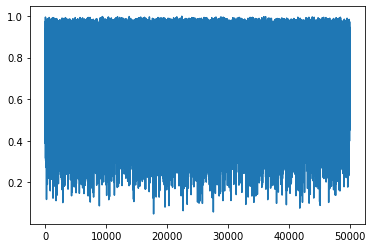

In [17]:
plt.plot(predictions)
plt.show()

In [18]:
def getPDsShift(shift):


  SNRs = np.arange(-20, 0)
  samplesPerBin = 2000

  numSamples = len(SNRs) * samplesPerBin
  samplesTotal = np.zeros(shape=(500, numSamples),dtype=complex)

  index = 0
  for SNR in SNRs:    
      for i in range(samplesPerBin):
          sample = genDopplerShiftedSine(SNR, shift)
          sample = np.divide(sample ,np.max(np.abs(sample)))
          samplesTotal[:,index] = sample
          index += 1

  samplesTotalNew = np.append(np.real(samplesTotal)[np.newaxis], np.imag(samplesTotal)[np.newaxis],axis=0)
  samplesTotalNew = np.swapaxes(samplesTotalNew,0,2)
  print(samplesTotalNew.shape)
  predictions = model.predict(samplesTotalNew)
  index = 0
  plt.plot(predictions)
  plt.show()
  pds = list()
  for SNR in SNRs:
    sampleResults = predictions[index:index +  samplesPerBin]
    index += samplesPerBin
    pd = np.sum(sampleResults < thresh) / samplesPerBin
    pds.append(pd)
    
  
  return pds

In [19]:
def matchedFilterPredict(sampleIn,FilterArray):
  results = np.zeros((100,)) 
  index = 0
  for matchedFilter in FilterArray:
    convResult = np.abs(np.convolve(matchedFilter, sampleIn))
    # plt.plot(convResult)
    # plt.show()
    results[index] = np.max(convResult)
    index += 1
  
  # plt.plot(results)
  # plt.show()
  return np.max(results)

In [20]:
def getPDsShiftMatchedFilter(shift):


  SNRs = np.arange(-20, 0)
  samplesPerBin = 100

  numSamples = len(SNRs) * samplesPerBin
  samplesTotal = np.zeros(shape=(500, numSamples),dtype=complex)

  index = 0
  for SNR in SNRs:    
      for i in range(samplesPerBin):
          sample = genDopplerShiftedSine(SNR, shift)
          sample = np.divide(sample ,np.max(np.abs(sample)))
          samplesTotal[:,index] = sample
          index += 1

  # samplesTotalNew = np.append(np.real(samplesTotal)[np.newaxis], np.imag(samplesTotal)[np.newaxis],axis=0)
  # samplesTotalNew = np.swapaxes(samplesTotalNew,0,2)
  # print(samplesTotalNew.shape)
  samplesTotal = np.swapaxes(samplesTotal,0,1)
  predictions = np.zeros((numSamples,))
  index = 0 

  
  matchedFilters = np.zeros((100,samplesTotal.shape[1]),dtype = complex)

  # print(matchedFilters.shape)
  for i in range(100):
    matchedFilters[i,:] = genDopplerShiftedSine(100, i)
    # plt.plot(matchedFilters[i,:])
    # plt.show()
  
  for sample in samplesTotal:
    predictions[index] = matchedFilterPredict(sample,matchedFilters)
    index +=1

  index = 0
  plt.plot(predictions)
  plt.show()
  pds = list()
  for SNR in SNRs:
    sampleResults = predictions[index:index +  samplesPerBin]
    index += samplesPerBin
    pd = np.sum(sampleResults > 150) / samplesPerBin
    pds.append(pd)
    
  
  return pds

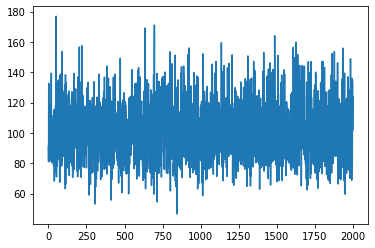

In [ ]:
PFA = getPDsShiftMatchedFilter(100000)

In [ ]:
MF50

[0.009,
 0.007,
 0.005,
 0.012,
 0.008,
 0.008,
 0.009,
 0.007,
 0.007,
 0.003,
 0.011,
 0.004,
 0.004,
 0.011,
 0.023,
 0.07,
 0.21,
 0.405,
 0.651,
 0.854]

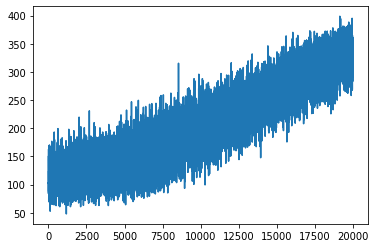

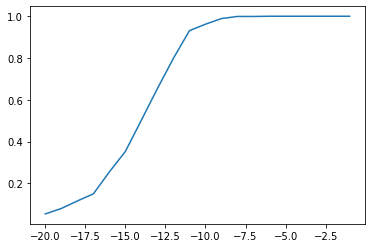

In [ ]:
MF0 = getPDsShiftMatchedFilter(0)
plt.plot(np.arange(-20,0),MF0)
plt.show()

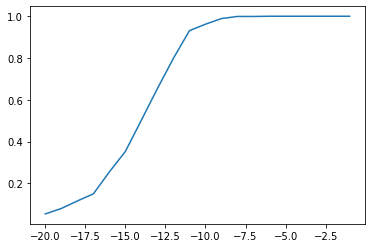

In [ ]:
plt.plot(np.arange(-20,0),MF0)
plt.show()

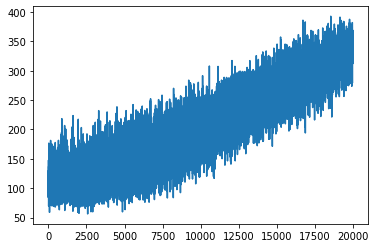

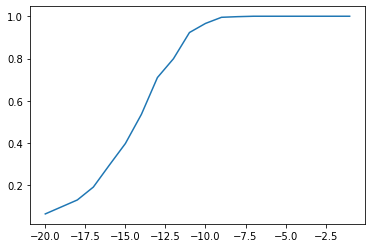

In [ ]:
MF10 = getPDsShiftMatchedFilter(10)
plt.plot(np.arange(-20,0),MF10)
plt.show()

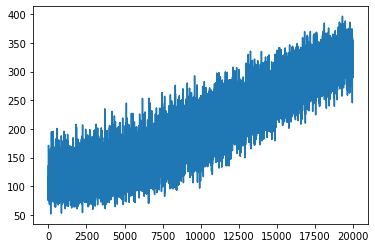

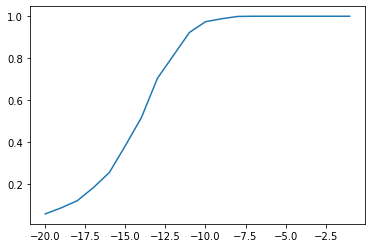

In [ ]:
MF20 = getPDsShiftMatchedFilter(20)
plt.plot(np.arange(-20,0),MF20)
plt.show()

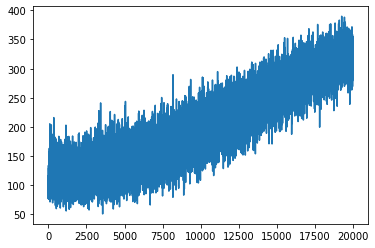

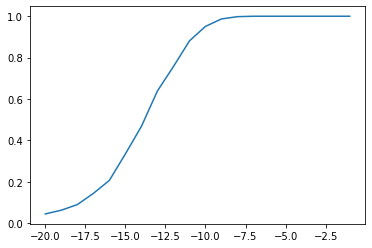

In [ ]:
MF30 = getPDsShiftMatchedFilter(30)
plt.plot(np.arange(-20,0),MF30)
plt.show()

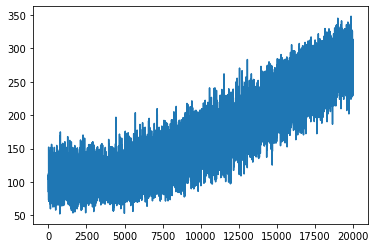

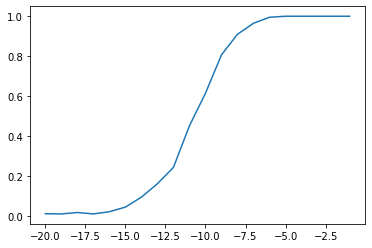

In [ ]:
MF40 = getPDsShiftMatchedFilter(40)
plt.plot(np.arange(-20,0),MF40)
plt.show()

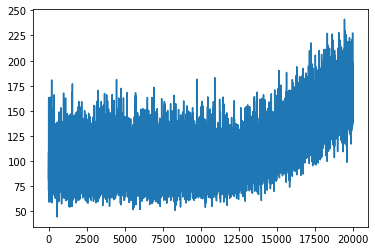

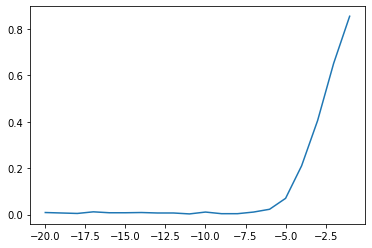

In [ ]:
MF50 = getPDsShiftMatchedFilter(50)
plt.plot(np.arange(-20,0),MF50)
plt.show()

In [ ]:
MF10

[0.065,
 0.098,
 0.131,
 0.192,
 0.296,
 0.398,
 0.536,
 0.71,
 0.799,
 0.923,
 0.966,
 0.995,
 0.998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
MF60 = getPDsShiftMatchedFilter(60)
plt.plot(np.arange(-20,0),MF60)
plt.show()

In [ ]:
MF70 = getPDsShiftMatchedFilter(70)
plt.plot(np.arange(-20,0),MF70)
plt.show()

In [ ]:
MF80 = getPDsShiftMatchedFilter(80)
plt.plot(np.arange(-20,0),MF80)
plt.show()

In [ ]:
MF90 = getPDsShiftMatchedFilter(90)
plt.plot(np.arange(-20,0),MF90)
plt.show()

In [ ]:
MF100 = getPDsShiftMatchedFilter(100)
plt.plot(np.arange(-20,10),MF100)
plt.show()

(40000, 500, 2)
1250/1250 [==============================] - 61s 49ms/step


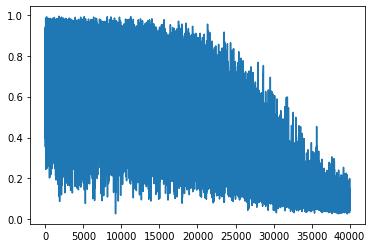

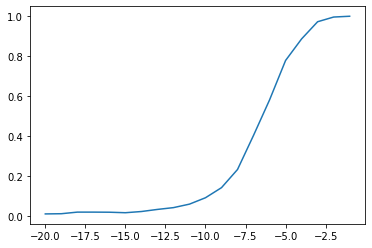

In [21]:
initial = getPDsShift(0)
plt.plot(np.arange(-20,0),initial)

In [ ]:
shift100 = getPDsShift(100)
plt.plot(np.arange(-20,0),shift100)

(40000, 500, 2)
1250/1250 [==============================] - 62s 49ms/step


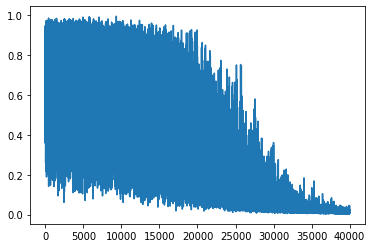

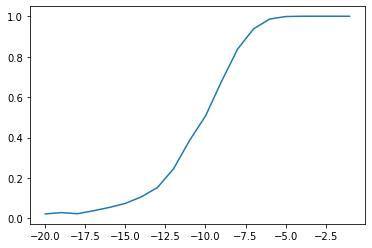

In [22]:
shift10 = getPDsShift(10)
plt.plot(np.arange(-20,0),shift10)

(40000, 500, 2)
1250/1250 [==============================] - 62s 50ms/step


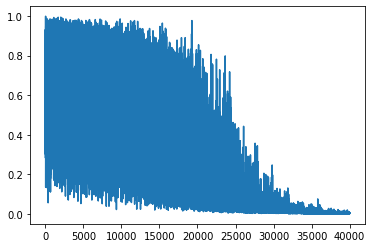

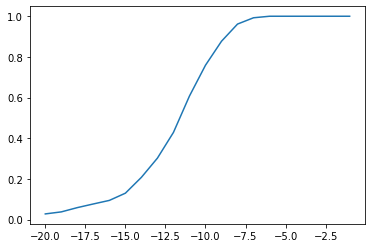

In [23]:
shift20 = getPDsShift(20)
plt.plot(np.arange(-20,0),shift20)

(40000, 500, 2)
1250/1250 [==============================] - 62s 50ms/step


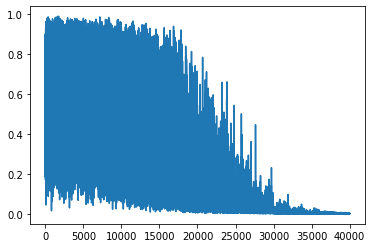

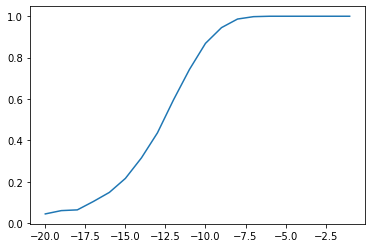

In [24]:
shift30 = getPDsShift(30)
plt.plot(np.arange(-20,0),shift30)

(40000, 500, 2)
1250/1250 [==============================] - 62s 50ms/step


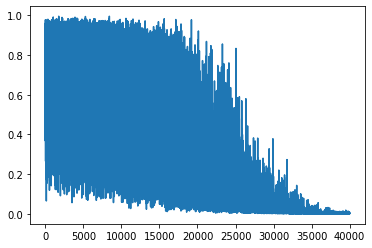

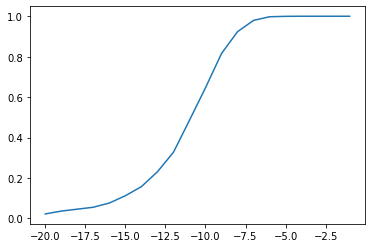

In [25]:
shift40 = getPDsShift(40)
plt.plot(np.arange(-20,0),shift40)

(40000, 500, 2)
1250/1250 [==============================] - 62s 50ms/step


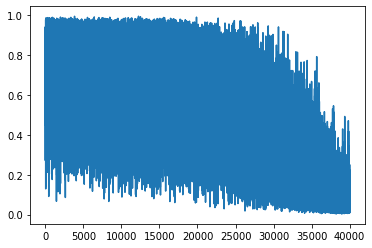

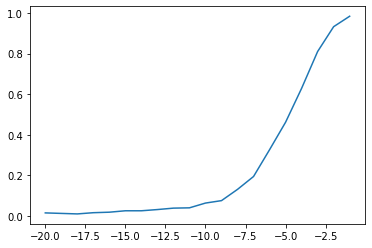

In [26]:
shift50 = getPDsShift(50)
plt.plot(np.arange(-20,0),shift50)

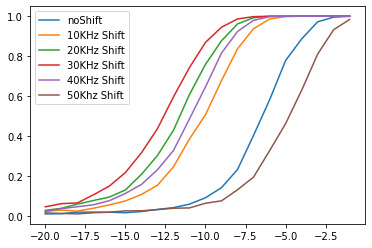

In [28]:
plt.plot(np.arange(-20,0),initial,label='noShift')
# plt.plot(np.arange(-20,0),shift5,label='5KHz Shift')
plt.plot(np.arange(-20,0),shift10,label='10KHz Shift')
# plt.plot(np.arange(-20,0),shift15,label='15KHz Shift')
plt.plot(np.arange(-20,0),shift20,label='20KHz Shift')
# plt.plot(np.arange(-20,0),shift25,label='25KHz Shift')
plt.plot(np.arange(-20,0),shift30,label='30KHz Shift')
# plt.plot(np.arange(-20,0),shift35,label='35KHz Shift')
plt.plot(np.arange(-20,0),shift40,label='40KHz Shift')
# plt.plot(np.arange(-20,0),shift45,label='45KHz Shift')
plt.plot(np.arange(-20,0),shift50,label='50Khz Shift')
# plt.plot(np.arange(-20,0),shift100,label='100Khz Shift')
plt.legend()
plt.show()


In [29]:
initial

[0.0095,
 0.0105,
 0.0185,
 0.0185,
 0.018,
 0.0155,
 0.0215,
 0.032,
 0.041,
 0.0585,
 0.0905,
 0.141,
 0.232,
 0.403,
 0.5805,
 0.778,
 0.886,
 0.972,
 0.9955,
 0.9995]

In [30]:
shift10

[0.0225,
 0.029,
 0.0235,
 0.038,
 0.0545,
 0.0745,
 0.107,
 0.153,
 0.245,
 0.385,
 0.5065,
 0.6775,
 0.837,
 0.9375,
 0.986,
 0.9985,
 1.0,
 1.0,
 1.0,
 1.0]

In [31]:
shift20

[0.0275,
 0.0375,
 0.0585,
 0.0765,
 0.094,
 0.1295,
 0.2075,
 0.302,
 0.4285,
 0.6075,
 0.759,
 0.877,
 0.9615,
 0.9925,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [32]:
shift30

[0.045,
 0.061,
 0.0645,
 0.105,
 0.149,
 0.2165,
 0.3155,
 0.4365,
 0.5955,
 0.743,
 0.869,
 0.945,
 0.9865,
 0.998,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [33]:
shift40

[0.022,
 0.036,
 0.0455,
 0.055,
 0.076,
 0.112,
 0.157,
 0.2305,
 0.327,
 0.4855,
 0.646,
 0.8155,
 0.9235,
 0.9795,
 0.9975,
 0.9995,
 1.0,
 1.0,
 1.0,
 1.0]

In [34]:
shift50

[0.0145,
 0.012,
 0.0095,
 0.0155,
 0.018,
 0.025,
 0.025,
 0.031,
 0.038,
 0.0395,
 0.063,
 0.075,
 0.1305,
 0.194,
 0.326,
 0.4615,
 0.6285,
 0.81,
 0.9325,
 0.984]

In [ ]:
shift100

In [ ]:
shift60 = getPDsShift(60)
plt.plot(np.arange(-20,0),shift60)

In [ ]:
shift60

In [ ]:
shift70 = getPDsShift(70)
plt.plot(np.arange(-20,0),shift70)

In [ ]:
shift70

In [ ]:
shift80 = getPDsShift(80)
plt.plot(np.arange(-20,0),shift80)

In [ ]:
shift80

In [ ]:
shift90 = getPDsShift(90)
plt.plot(np.arange(-20,0),shift90)

In [ ]:
shift90